In [141]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import rc

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

PATH='AI_Human.csv'

In [142]:
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

df=pd.read_csv(path + '/AI_Human.csv')
df

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


In [143]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer # 다음 단어 예측을 위해 LMHeadModel 사용
import torch
import torch.nn.functional as F

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


====== AI 텍스트 샘플 ======


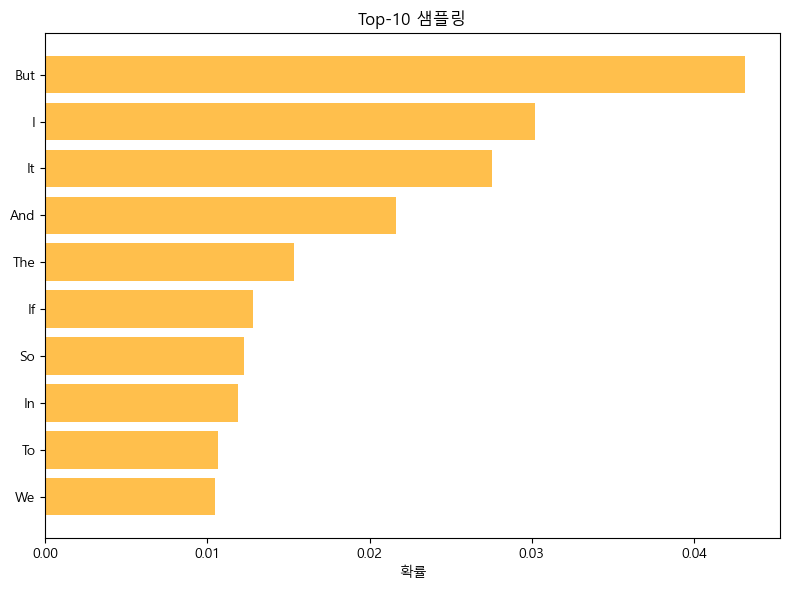


=== Top-k 샘플링 결과 ===
1. 'But': 0.0431 (4.31%)
2. 'I': 0.0302 (3.02%)
3. 'It': 0.0275 (2.75%)
4. 'And': 0.0217 (2.17%)
5. 'The': 0.0154 (1.54%)
6. 'If': 0.0128 (1.28%)
7. 'So': 0.0122 (1.22%)
8. 'In': 0.0119 (1.19%)
9. 'To': 0.0107 (1.07%)
10. 'We': 0.0105 (1.05%)

====== 인간 텍스트 샘플 ======


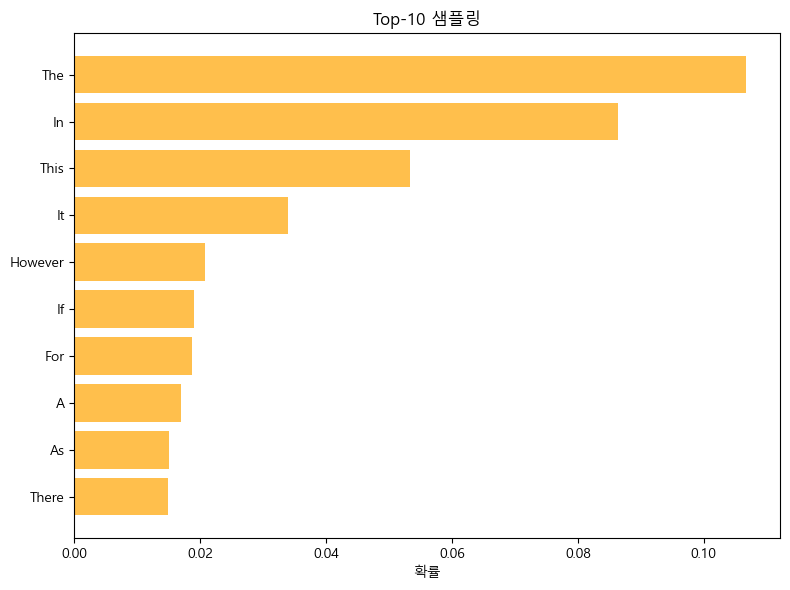


=== Top-k 샘플링 결과 ===
1. 'The': 0.1068 (10.68%)
2. 'In': 0.0864 (8.64%)
3. 'This': 0.0533 (5.33%)
4. 'It': 0.0340 (3.40%)
5. 'However': 0.0207 (2.07%)
6. 'If': 0.0189 (1.89%)
7. 'For': 0.0186 (1.86%)
8. 'A': 0.0169 (1.69%)
9. 'As': 0.0150 (1.50%)
10. 'There': 0.0149 (1.49%)


In [163]:
import re

ai_samples = df[df['generated'] == 0]
human_samples = df[df['generated'] == 1]

#전처리
def preprocess_text(text):
    return text.strip()
sample_text = preprocess_text(ai_samples.iloc[0]['text'])

def filter_special_tokens(words, special_tokens=["<|endoftext|>", ""]):
    return [word for word in words if word not in special_tokens]


def filter_tokens_and_probs(words, probs, special_tokens=["<|endoftext|>", ""]):
    filtered_words = []
    filtered_probs = []
    for word, prob in zip(words, probs):
        # 특수 토큰 필터링
        if word not in special_tokens and not re.match(r"^[_~]+$.*()", word):
            filtered_words.append(word)
            filtered_probs.append(prob)
    return filtered_words, filtered_probs

def visualize_sampling_limited_words(text, model, tokenizer, top_k=10):
    if not text:
        print("입력 텍스트가 비어 있습니다.")
        return

    inputs = tokenizer.encode(text, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits[:, -1, :]
        probs = F.softmax(logits, dim=-1).squeeze()
    
    # top-k
    top_k_probs, top_k_indices = torch.topk(probs, k=top_k * 2) 
    top_k_words = [tokenizer.decode([idx.item()]).strip() for idx in top_k_indices]

    # 특수 토큰 필터링
    top_k_words, top_k_probs = filter_tokens_and_probs(top_k_words, top_k_probs.cpu().numpy())

    # 부족한 토큰 채우기
    if len(top_k_words) < top_k:
        remaining_indices = torch.argsort(probs, descending=True)[top_k:]  # top-k 이후의 토큰
        for idx in remaining_indices:
            word = tokenizer.decode([idx.item()]).strip()
            prob = probs[idx].item()
            if word not in top_k_words and word not in ["<|endoftext|>", ""] and not re.match(r"^[_~]+$", word):
                top_k_words.append(word)
                top_k_probs.append(prob)
            if len(top_k_words) == top_k:
                break

    top_k_words = top_k_words[:top_k]
    top_k_probs = top_k_probs[:top_k]

    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.barh(range(len(top_k_words)), top_k_probs, color='orange', alpha=0.7)
    ax.set_yticks(range(len(top_k_words)))
    ax.set_yticklabels(top_k_words)
    ax.invert_yaxis()
    ax.set_title(f"Top-{top_k} 샘플링")
    ax.set_xlabel("확률")
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== Top-k 샘플링 결과 ===")
    for i, (word, prob) in enumerate(zip(top_k_words, top_k_probs)):
        print(f"{i+1}. '{word}': {prob:.4f} ({prob*100:.2f}%)")


sample_text = ai_samples.iloc[0]['text']
print("\n====== AI 텍스트 샘플 ======")
visualize_sampling_limited_words(sample_text, model, tokenizer, top_k=10)

sample_text = human_samples.iloc[0]['text']
print("\n====== 인간 텍스트 샘플 ======")
visualize_sampling_limited_words(sample_text, model, tokenizer, top_k=10)
